## INVESTIGATE THE DATASET

In [1]:
import pandas as pd
from cleaning_functions import fatality
import matplotlib.pyplot as plt


Firs, let's import the clean dataset:

In [18]:
data = pd.read_csv('data_sharks_clean.csv')

To begin with, it is a good idea to take a look at the raw numbers:<br> **How many attacks could I classify to have happened during the night and during the day?**

Day      2568
Night     318
Name: night_day, dtype: int64


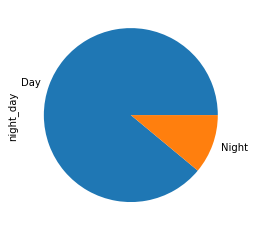

In [19]:
print(data.night_day.value_counts())
data.night_day.value_counts().plot.pie()

Not surprisingly, most of the attacks have happened during the day.There is usually more people in the water during the day that during the night. <br> This same pattern shows up when looking at the total number of fatal accidents during the day and night:

N    2042
Y     410
Name: fatal, dtype: int64
N    219
Y     71
Name: fatal, dtype: int64


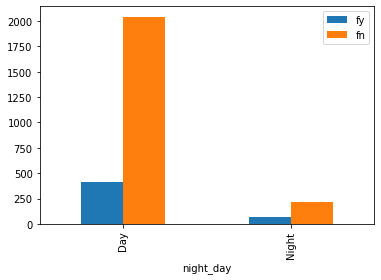

In [20]:
print(data.loc[data.night_day=='Day','fatal'].value_counts())
print(data.loc[data.night_day=='Night','fatal'].value_counts())
data.groupby(['night_day']).agg({'fy':'sum',
                                'fn':'sum'}).plot.bar()

However, these raw numbers are difficult to interpret. One way to meassure the severity of the attacks is checking for the percentage of fatal attacks:

In [21]:
#We use the custom function fatality to calculate % of fatal attacks.
overall_fatality = fatality(data['fatal'])
print(f"The overall fatality is {round(overall_fatality,2)}%")

The overall fatality is 16.67%


night_day
Day      15.965732
Night    22.327044
Name: fatal, dtype: float64


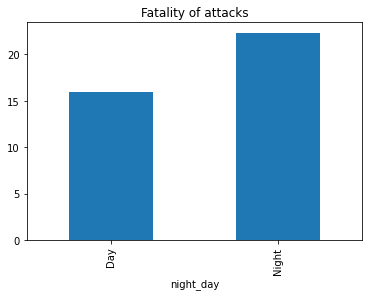

In [22]:
print(data.groupby(['night_day']).fatal.apply(fatality))
data.groupby(['night_day']).fatal.apply(fatality).plot.bar(title='Fatality of attacks')

Total number of cases per activity and day night
   activity night_day  fatal
0   fishing       Day    335
1   fishing     Night     64
2     other       Day    192
3     other     Night     52
4  standing       Day    212
5  standing     Night     12
6   surfing       Day   1040
7   surfing     Night    108
8  swimming       Day    789
9  swimming     Night     82


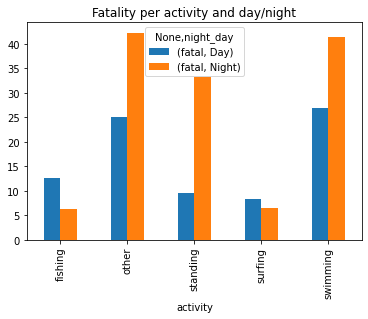

In [23]:
print('Total number of cases per activity and day night')
print(data[['activity','night_day','fatal']].groupby(['activity','night_day']).fatal.agg(len).reset_index())

data.pivot_table(values=['fatal'], index=['activity'], columns=['night_day'], aggfunc=fatality).plot.bar(title='Fatality per activity and day/night')

In [24]:
data[['decade','fatal', 'night_day']].groupby(['decade','night_day']).agg('count').sort_values(by='fatal', ascending = False).reset_index()

,decade,night_day,fatal
0,2000,Day,631
1,2010,Day,590
2,1950bef,Day,398
3,1990,Day,308
4,1960,Day,234
5,1980,Day,185
6,1970,Day,106
7,1950bef,Night,82
8,2000,Night,68
9,2010,Night,50


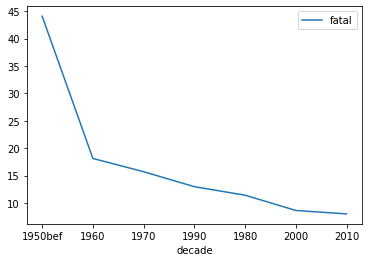

In [28]:
data[['decade','fatal']].groupby(['decade']).agg(fatality).sort_values(by='fatal', ascending = False).reset_index().plot('decade', 'fatal')

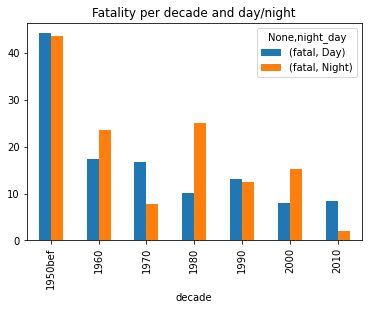

In [26]:
data.pivot_table(values=['fatal'], index=['decade'], columns=['night_day'], aggfunc=fatality).plot.bar(title='Fatality per decade and day/night')

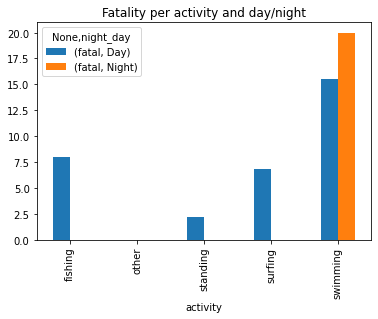

In [27]:
data[data.decade == '2010'].pivot_table(values=['fatal'], index=['activity'], columns=['night_day'], aggfunc=fatality).plot.bar(title='Fatality per activity and day/night')

## BONUS. How many deads by shark per country?

In [29]:
data_country = pd.read_csv('data_country.csv')

In [44]:
data_country['n_fatal'] = data_country['fatal'].apply(lambda x: 1 if x=='Y' else 0)
data_country[['fatal','n_fatal']]

,fatal,n_fatal
0,N,0
1,N,0
2,N,0
3,N,0
4,N,0
...,...,...
5804,Y,1
5805,Y,1
5806,Y,1
5807,Y,1


In [53]:
dta = data_country[['country', 'population','n_fatal']].groupby('country').agg({'population':'first','n_fatal':'sum'}).reset_index()
dta = pd.DataFrame(dta).set_index('country')
dta['per_mill'] = (dta.n_fatal/dta.population)*1000000
dta

,population,n_fatal,per_mill
country,,,
algeria,38700000.0,1,0.025840
american samoa,55519.0,3,54.035555
angola,24383301.0,0,0.000000
argentina,42669500.0,0,0.000000
aruba,101484.0,1,9.853770
...,...,...,...
uruguay,3404189.0,2,0.587511
vanuatu,264652.0,9,34.006922
venezuela,30206307.0,4,0.132423


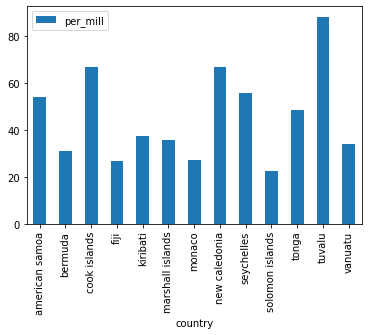

In [55]:
dta[['per_mill']][dta.per_mill>20].plot.bar()

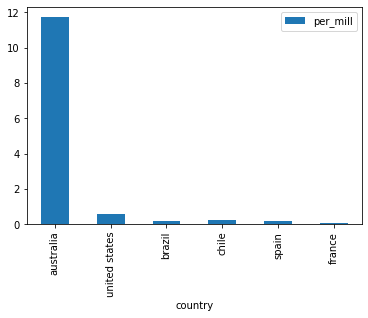

In [80]:
dta.loc[['australia','united states', 'brazil', 'chile','spain','france'],][['per_mill']].plot.bar()